In [1]:
import torch, torchhd
import torch.nn as nn

In [2]:
import torchhd
from torchhd.models import Centroid
from torchhd import embeddings

In [3]:
import torchmetrics
from tqdm import tqdm

In [4]:
import sys
import struct
import numpy as np
import sklearn
from sklearn import preprocessing
def readChoirData(dir,data_path, data_type):

    filename = dir + data_path + "_" + data_type + ".choir_dat"
    param = dict()

    with open(filename, 'rb') as f:
        nFeatures = struct.unpack('i', f.read(4))[0]
        nClasses = struct.unpack('i', f.read(4))[0]
        X = []
        y = []
        while True:
            newDP = []
            for i in range(nFeatures):
                v_in_bytes = f.read(4)
                if v_in_bytes is None or len(v_in_bytes) == 0:
                    # TODO very unprofessionally normalizing data
                    X = preprocessing.normalize(np.asarray(X), norm='l2')
                    param["nFeatures"], param["nClasses"], param["data"], param["labels"] = \
                        nFeatures, nClasses, X, np.asarray(y)
                    return param
                v = struct.unpack('f', v_in_bytes)[0]
                newDP.append(v)
            l = struct.unpack('i', f.read(4))[0]
            X.append(newDP)
            y.append(l)

train_data  = readChoirData('../isolet/','isolet', 'train')
test_data= readChoirData('../isolet/','isolet', 'test')

In [6]:
class Encoder(nn.Module):
    def __init__(self, out_features, size):
        super(Encoder, self).__init__()
        self.encoder = embeddings.Sinusoid(size,out_features)

    def forward(self, x):
        sample_hv = self.encoder(x)
        return sample_hv


In [8]:
result = []
for dim in range(1000,7000,1000):
    encode = Encoder(dim,train_data['nFeatures'])
    model =Centroid(dim,train_data['nClasses'])
    with torch.no_grad():
        for samples, labels in tqdm(zip(train_data['data'],train_data['labels']), desc="Training"):
            samples = torch.Tensor(samples)
            labels = torch.from_numpy(np.array(labels))
            samples_hv = encode(samples)
            model.add(samples_hv, labels)

    accuracy = torchmetrics.Accuracy("multiclass", num_classes=train_data['nClasses'])
    with torch.no_grad():
        model.normalize()

        for samples, labels in tqdm(zip(train_data['data'],train_data['labels']), desc="Testing"):
            samples = torch.Tensor(samples)
            labels = torch.from_numpy(np.array([labels]))
            samples_hv = encode(samples)
            outputs = np.argmax(model(samples_hv, dot=True)).view(-1)
            accuracy.update(outputs, labels)
    result.append(accuracy.compute())

Training: 6238it [00:00, 9659.44it/s]
Testing: 6238it [00:02, 2932.74it/s]
Training: 6238it [00:00, 6345.15it/s]
Testing: 6238it [00:02, 2458.04it/s]
Training: 6238it [00:01, 3815.96it/s]
Testing: 6238it [00:03, 1884.98it/s]
Training: 6238it [00:02, 2554.92it/s]
Testing: 6238it [00:04, 1379.41it/s]
Training: 6238it [00:03, 2002.22it/s]
Testing: 6238it [00:05, 1207.34it/s]
Training: 6238it [00:03, 1709.37it/s]
Testing: 6238it [00:06, 1036.19it/s]


(0.85, 0.92)

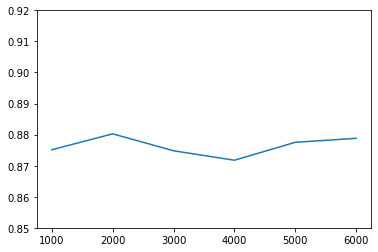

In [25]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)
ax.plot(range(1000,7000,1000),result)
ax.set_ylim([0.85,0.92])